<a href="https://colab.research.google.com/github/andrew-ryabchenko/DS-Unit-2-Kaggle-Challenge/blob/master/LS_DS_224_guided_project_notes(Nicholas_Lecture).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

- get and interpret the **confusion matrix** for classification models
- use classification metrics: **precision, recall**
- understand the relationships between precision, recall, **thresholds, and predicted probabilities**, to help **make decisions and allocate budgets**
- Get **ROC AUC** (Receiver Operating Characteristic, Area Under the Curve)

In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [ ]:
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd

# I. Wrangle Data

## Import

In [ ]:
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv')).set_index('id')

test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv', index_col='id')

## EDA

- How can we transform our target so that this is a **binary classification** problem?

In [ ]:
train['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

* non functional            1   
* functional needs repair   1
* functional 0

Our new wrangle function

In [ ]:
def wrangle(X):
  # Make a copy
  X = X.copy()

  # Drop high cardinality cols
  high_card_cols = [col for col in X.select_dtypes('object').columns
                    if X[col].nunique() > 100]

  X.drop(columns=high_card_cols, inplace=True)

  # Drop repeated columns
  cols = ['extraction_type_group', 'quantity']
  X.drop(columns=cols, inplace=True)

  # Create new binary target 
  if ('status_group' in X.columns):
    X['needs_repair'] = X['status_group'].apply(lambda x: 0 if x=='functional' else 1)
    X.drop(columns=['status_group'], inplace=True)
  
  return X

In [ ]:
train = wrangle(train)
test = wrangle(test)

# II. Split Data

In [ ]:
# Split TV / FM
target = 'needs_repair'
y = train[target]
X = train.drop(columns=target)

# Train-val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Sanity check
assert len(X_train) + len(X_val) == len(X)

# Baseline

In [ ]:
print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.5429713804713805


# Build Models
- `Ordinal Encoder`
- `RandomForestClassifier`
- `SimpleImputer`

In [ ]:
model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_jobs = -1, n_estimators = 50, random_state = 42)
)
model.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'recorded_by', 'scheme_management',
                                      'permit', 'extraction_type',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity_group',
                                      'source', 'source_type', 'source_class',
                                      'waterpoint_type',
                                      'w...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                

# Check Metrics

**Accuracy**


In [ ]:
model.score(X_val,y_val)

0.8191077441077441

**Confusion Matrix**

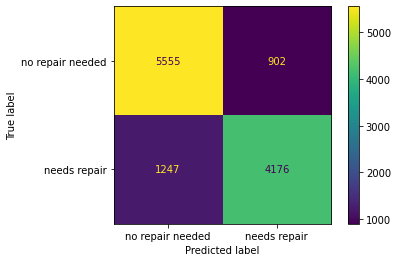

In [ ]:
plot_confusion_matrix(model,X_val,y_val,
                      values_format = '.0f',
                      display_labels = ['no repair needed', 'needs repair'])

4135 / (4135+875)

In [ ]:
4135 / (4135+875)

0.8253493013972056

In [ ]:
print(classification_report(y_val, model.predict(X_val)))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84      6457
           1       0.82      0.77      0.80      5423

    accuracy                           0.82     11880
   macro avg       0.82      0.82      0.82     11880
weighted avg       0.82      0.82      0.82     11880



# Case Study

Let's say that is costs the Tanzanian government $100 to inspect a water pump, and there is only funding for 2000 pump inspections. 

In [ ]:
n_inspections = 2000

Scenario 1: Choose pumps randomly

Scenario 2: Using our model "out of the box"

Scenario 3